In [1]:
import os
import keras
import random
from keras.applications.inception_v3 import preprocess_input# import inception_v3 as inc_net
from keras.preprocessing import image
from keras.models import load_model
from skimage.io import imread
from skimage.segmentation import mark_boundaries
#from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.1.6


In [2]:
img_size = 299
data_type = 'tabak'
path_to_labels = os.path.join('labels', data_type+'.txt')
file_name = os.path.join('trainedModels',
                         data_type,
                         'completetrain',
                         '16-07-18 15:39__Epochs11_Steps40_ImageSize299_BatchSize16')
def getHighestID(preds):
    id = 0
    max = -1
    for i in range(len(preds)):
        if preds[i]>max:
            max = preds[i]
            id=i
    return id

def getLabels():
    with open(path_to_labels, 'r') as f:
     myLabels = [line.strip() for line in f]
    return myLabels

def getLabelById(id):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if i == id:
                return line
    raise Exception('ID is not in file')
    
def decode_prediction(preds):
    label_list = getLabels()    
    decoded_list = list()
    decoded_list.append([])
    for i in range(len(label_list)):
        decoded_list[0].append([label_list[i],preds[i]])
    return decoded_list

def getIdByLabel(label):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if label == line.replace('\n',''):
                return i
    raise Exception('Label is not in file')

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

def getRandomImage():
    dir_list = [x[0] for x in os.walk(os.path.join('data',data_type,'test'))][1:]
    output = list()
    only_paths = list()
    for x in dir_list:
        output.append([random.choice(os.listdir(x)),os.path.basename(x)])
        only_paths.append(os.path.join(x,random.choice(os.listdir(x))))
    return output, only_paths    


In [3]:
my_model = load_model(file_name+".h5")
print('Model loaded> '+file_name)

Model loaded> trainedModels/tabak/completetrain/16-07-18 15:39__Epochs11_Steps40_ImageSize299_BatchSize16


In [4]:
output, images_paths = getRandomImage()
images = transform_img_fn(images_paths)
preds = my_model.predict(images)

['Schlecht', 0.82549304]
['Gut', 0.17450698]
True


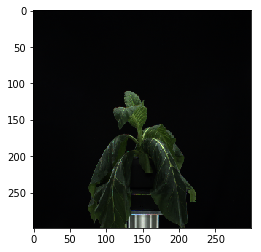

['Gut', 0.9999981]
['Schlecht', 1.951036e-06]
True


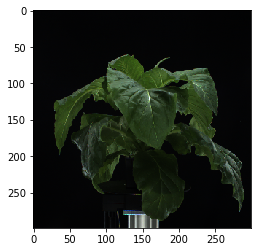

In [5]:
for i in range(len(images)):
    preds_with_labels = decode_prediction(preds[i])[0]
    preds_with_labels = sorted(preds_with_labels,key=lambda l:l[1], reverse=True)
    plt.figure()
    plt.imshow(images[i]/2 +0.5)    
    for x in preds_with_labels[:5]:
        print(x)
    isright = True if preds_with_labels[0][0] == output[i][1] else False
    print(isright)
    plt.show()

In [6]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [7]:
explainer = lime_image.LimeImageExplainer()

In [8]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explantions = list()
for image in images:
    explantions.append(explainer.explain_instance(image, my_model.predict, hide_color=None, num_samples=1000))

CPU times: user 25.4 s, sys: 2.67 s, total: 28.1 s
Wall time: 26.9 s


Schlecht / 


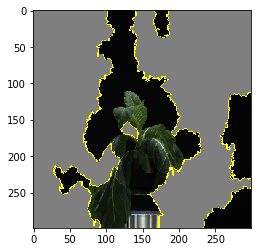

Gut
 / 


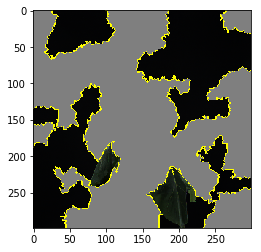

Gut
 / 


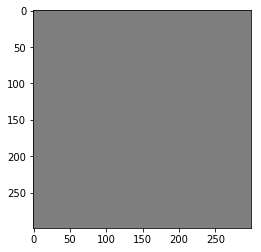

Schlecht / 


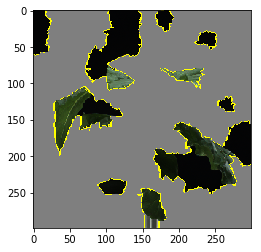

In [9]:
for i in range(len(explantions)):
    if data_type == 'tabak':
        neg = 0 if getHighestID(preds[i]) == 1 else 1
        temp, mask = explantions[i].get_image_and_mask(getHighestID(preds[i]),
                                                   positive_only=True,
                                                   hide_rest=True,
                                                   num_features=20)
        print(getLabelById(getHighestID(preds[i])) + " / ") #ToDO: getFileName
        plt.figure()
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.show()
        temp, mask = explantions[i].get_image_and_mask(neg,
                                                   positive_only=True,
                                                   hide_rest=True,
                                                   num_features=20)
        print(getLabelById(neg) + " / ") #ToDO: getFileName
        plt.figure()
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.show()
    else:
        temp, mask = explantions[i].get_image_and_mask(getHighestID(preds[i]),
                                                   positive_only=True,
                                                   hide_rest=True,
                                                   num_features=20)
        print(getLabelById(getHighestID(preds[i])) + " / ") #ToDO: getFileName
        plt.figure()
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.show()